In [1]:
import os
import random
import torch
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import dill
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from copy import deepcopy
import torch
from torch import nn
import torch.nn.functional as F
import lovely_tensors as lt
lt.monkey_patch()

import csng
from csng.models.inverted_encoder import InvertedEncoder, InvertedEncoderBrainreader
from csng.models.ensemble import EnsembleInvEnc
from csng.models.utils.gan import init_decoder as init_gan_decoder
from csng.models.utils.cnn import init_decoder as init_cnn_decoder
from csng.models.inverted_encoder_decoder import InvertedEncoderDecoder
from csng.utils.mix import seed_all, check_if_data_zscored, update_config_paths, update_config
from csng.utils.data import standardize, normalize, crop
from csng.utils.comparison import find_best_ckpt, load_decoder_from_ckpt, plot_reconstructions, plot_metrics, eval_decoder, SavedReconstructionsDecoder, collect_all_preds_and_targets
from csng.losses import get_metrics
from csng.data import get_dataloaders, get_sample_data
from csng.brainreader_mouse.encoder import get_encoder as get_encoder_brainreader
from csng.mouse_v1.encoder import get_encoder as get_encoder_sensorium_mouse_v1
from csng.cat_v1.encoder import get_encoder as get_encoder_cat_v1

# from monkeysee.SpatialBased.decoding_wrapper import MonkeySeeDecoder


### set paths
DATA_PATH = os.environ["DATA_PATH"]
DATA_PATH_CAT_V1 = os.path.join(DATA_PATH, "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(DATA_PATH, "mouse_v1_sensorium22")
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, "brainreader")

print(f"{DATA_PATH=}")
print(f"{DATA_PATH_CAT_V1=}")
print(f"{DATA_PATH_MOUSE_V1=}")
print(f"{DATA_PATH_BRAINREADER=}")

DATA_PATH='/media/jan/ext_ssd/csng_data'
DATA_PATH_CAT_V1='/media/jan/ext_ssd/csng_data/cat_V1_spiking_model/50K_single_trial_dataset'
DATA_PATH_MOUSE_V1='/media/jan/ext_ssd/csng_data/mouse_v1_sensorium22'
DATA_PATH_BRAINREADER='/media/jan/ext_ssd/csng_data/brainreader'


In [1090]:
### setup config
config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
        "max_training_batches": None,
    },
    "crop_wins": dict(),
}

print(f"... Running on {config['device']} ...")
seed_all(config["seed"])

... Running on cuda:0 ...


# Data

In [1091]:
### brainreader mouse data
config["data"]["brainreader_mouse"] = {
    "device": config["device"],
    "mixing_strategy": config["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": 36,
    # "sessions": list(range(1, 23)),
    # "sessions": [1, 2, 3, 4, 5, 6, 7, 8],
    "sessions": [6],
    "resize_stim_to": (36, 64),
    "normalize_stim": True,
    "normalize_resp": False,
    "div_resp_by_std": True,
    "clamp_neg_resp": False,
    "additional_keys": None,
    "avg_test_resp": True,
    "drop_last": True,
}
_dls, _ = get_dataloaders(config=config)
for data_key, dset in zip(_dls["train"]["brainreader_mouse"].data_keys, _dls["train"]["brainreader_mouse"].datasets):
    config["crop_wins"][data_key] = tuple(dset[0].images.shape[-2:])

In [1089]:
### cat v1 data
config["data"]["cat_v1"] = {
    "crop_win": (20, 20),
    "dataset_config": {
        "train_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "train"),
        "val_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "val"),
        "test_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "test"),
        "image_size": [50, 50],
        "crop": False,
        "batch_size": 36,
        "stim_keys": ("stim",),
        "resp_keys": ("exc_resp", "inh_resp"),
        "return_coords": True,
        "return_ori": False,
        "coords_ori_filepath": os.path.join(DATA_PATH_CAT_V1, "pos_and_ori.pkl"),
        "cached": False,
        "stim_normalize_mean": 46.143,
        "stim_normalize_std": 24.960,
        "resp_normalize_mean": None,
        "resp_normalize_std": torch.load(
            os.path.join(DATA_PATH_CAT_V1, "responses_std.pt")
        ),
    },
}
# add crop_wins for cat v1 data
config["crop_wins"]["cat_v1"] = config["data"]["cat_v1"]["crop_win"]

In [1085]:
### sensorium 2022 mouse v1 data
config["data"]["mouse_v1"] = {
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
            os.path.join(DATA_PATH_MOUSE_V1, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-1
            # os.path.join(DATA_PATH_MOUSE_V1, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-2
            # os.path.join(DATA_PATH_MOUSE_V1, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-3
            # os.path.join(DATA_PATH_MOUSE_V1, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-4
            # os.path.join(DATA_PATH_MOUSE_V1, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-5
        ],
        "normalize": True,
        "z_score_responses": False,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": "cuda" in config["device"],
        "batch_size": 16,
        # "seed": config["seed"],
        "use_cache": False,
    },
    "crop_win": (22, 36),
    "skip_train": False,
    "skip_val": False,
    "skip_test": False,
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 36,
    "device": config["device"],
}
### add crop_wins for mouse v1 data
for data_key, n_coords in get_dataloaders(config=config)[0]["train"]["mouse_v1"].neuron_coords.items():
    config["crop_wins"][data_key] = config["data"]["mouse_v1"]["crop_win"]

In [1092]:
dls, neuron_coords = get_dataloaders(config)
for tier, data_dict in dls.items():
    print(f"{tier}:")
    for data_name, dl in data_dict.items():
        # for data_key, dset in zip(dl.data_keys, dl.datasets):
        #     config["crop_wins"][data_key] = tuple(dset[0].images.shape[-2:])
        print(f"  {data_name}: {len(dl)} batches")
        print(f"    data keys: {', '.join(dl.data_keys)}")
        print(f"    size of datasets: {', '.join([str(len(dl) * _dl.batch_size) for _dl in dl.dataloaders])}")

train:
  brainreader_mouse: 125 batches
    data keys: 6
    size of datasets: 4500
val:
  brainreader_mouse: 13 batches
    data keys: 6
    size of datasets: 468
test:
  brainreader_mouse: 1 batches
    data keys: 6
    size of datasets: 36


Training dataset:	 4500 samples
Validation dataset:	 468 samples
Test dataset:		 36 samples

stimuli:
  torch.Size([36, 1, 36, 64])
  min=-2.333  max=2.915
  mean=-0.071  std=1.244
responses:
  torch.Size([36, 8587])
  min=-0.000  max=38.704
  mean=0.448  std=1.081


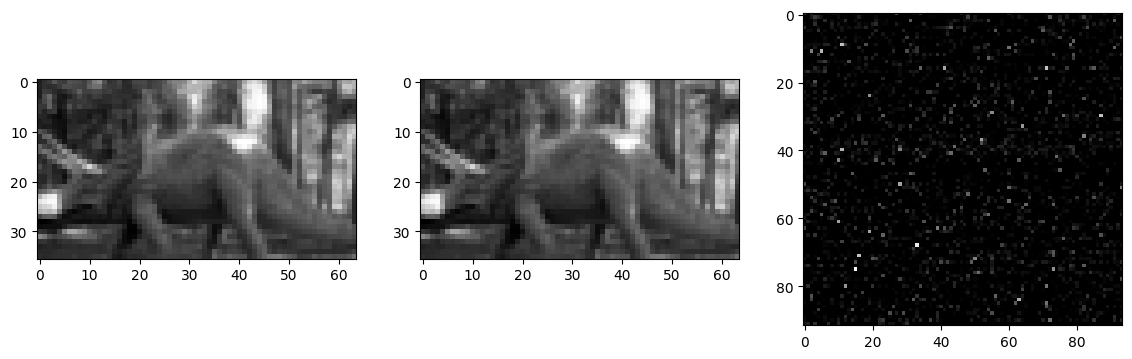

In [1093]:
### show data
# sample_dataset = "mouse_v1"
# sample_data_key = "21067-10-18"
sample_dataset = "brainreader_mouse"
sample_data_key = "6"
tier = "val"
sample_idx = 0

datapoint = next(iter(dls[tier][sample_dataset].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['train'][sample_dataset].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['val'][sample_dataset].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in dls['test'][sample_dataset].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
)

### plot sample data
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].cpu().squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_wins"][sample_data_key]).squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(133)
to_show = resp[sample_idx].cpu()
### pad with zeros
if to_show.shape[-1] % (w := np.sqrt(resp[sample_idx].cpu().shape[0]).astype(int)) != 0:
    to_show = torch.cat([to_show, torch.zeros(w - to_show.shape[-1] % w)], dim=-1)
ax.imshow(to_show.view(w, -1).squeeze(0).unsqueeze(-1), cmap="gray")

In [ ]:
# Check duplicates
import torch
import numpy as np
from tqdm.notebook import tqdm
import hashlib

# --- Configuration ---
# Define the datasets and data keys to check.
# The keys of the dictionary are the dataset names used in the `dls` variable.
# The values are the specific data_keys for that dataset.
datasets_to_check = {
    "brainreader_mouse": ["6"],
    "mouse_v1": ["21067-10-18"],
    # "cat_v1": ["cat_v1"],
}

# Tiers to include in the check
tiers_to_check = ["val","test"]

print("--- Starting Cross-Dataset Duplicate Image Check ---")

# --- Data Structures to Store Hashes and Duplicates ---
# We'll map a SHA256 hash to the location where it was first seen.
# Using SHA256 is more robust than Python's built-in hash() for this task.
seen_image_hashes = {}  # { hash_str: (dataset_name, data_key, tier, batch_idx, img_idx_in_batch) }
duplicate_records = []  # List to store info about found duplicates

# --- Main Loop ---
# Use tqdm for a progress bar, iterating over a flat list of all tasks.
tasks = []
for dset_name, data_keys in datasets_to_check.items():
    for data_key in data_keys:
        for tier in tiers_to_check:
            tasks.append((dset_name, data_key, tier))

for dset_name, data_key, tier in tasks:
    if dset_name not in dls[tier] or not hasattr(dls[tier][dset_name], 'dataloaders'):
        print(f"Skipping: No dataloader found for {dset_name} / {data_key} in tier '{tier}'")
        continue
        
    # Assuming there's one dataloader per data_key for simplicity
    # If there can be more, you would loop through dls[tier][dset_name].dataloaders
    dataloader = dls[tier][dset_name].dataloaders[0]

    for batch_idx, batch in enumerate(dataloader):
        # Ensure images are on CPU for hashing
        images = batch.images.cpu()

        for img_idx_in_batch in range(images.shape[0]):
            image_tensor = images[img_idx_in_batch]

            # Convert tensor to a byte string and compute its SHA256 hash
            image_bytes = image_tensor.numpy().tobytes()
            current_hash = hashlib.sha256(image_bytes).hexdigest()
            
            current_location_info = (dset_name, data_key, tier, batch_idx, img_idx_in_batch)

            # Check if this hash has been seen before
            if current_hash in seen_image_hashes:
                original_location_info = seen_image_hashes[current_hash]
                # Avoid flagging an image as a duplicate of itself if dataloaders have shuffle=False
                if original_location_info != current_location_info:
                    duplicate_records.append({
                        "duplicate_location": current_location_info,
                        "original_location": original_location_info,
                        "hash": current_hash,
                    })
            else:
                # If it's a new image, store its hash and location
                seen_image_hashes[current_hash] = current_location_info

# --- Report Results ---
print("\n--- Duplicate Check Complete ---")

if not duplicate_records:
    print(f"\n✅ SUCCESS: No duplicate images were found across the {len(seen_image_hashes)} unique images in the specified datasets.")
else:
    print(f"\n🚨 WARNING: Found {len(duplicate_records)} duplicate image instances!")
    for i, record in enumerate(duplicate_records):
        print(f"\n--- Duplicate Pair {i+1} ---")
        orig_dset, orig_key, orig_tier, orig_b, orig_i = record['original_location']
        dupe_dset, dupe_key, dupe_tier, dupe_b, dupe_i = record['duplicate_location']
        
        print(f"  Image Hash: {record['hash'][:16]}...")
        print(f"  First seen at:  Dataset='{orig_dset}', Key='{orig_key}', Tier='{orig_tier}', Batch={orig_b}, Img={orig_i}")
        print(f"  Duplicate found at: Dataset='{dupe_dset}', Key='{dupe_key}', Tier='{dupe_tier}', Batch={dupe_b}, Img={dupe_i}")

print("\n--------------------------------")

In [ ]:
for b in dls["test"]["cat_v1"].dataloaders[0]:
    # Plot all images in the batch
    n_imgs = b.images.shape[0]
    fig, axs = plt.subplots(4, n_imgs // 4, figsize=(n_imgs // 1.5, 6))
    for i in range(n_imgs):
        axs[i // 9, i % (n_imgs // 4)].imshow(b.images[i].cpu().squeeze().unsqueeze(-1), cmap="gray")
        axs[i // 9, i % (n_imgs // 4)].axis("off")
print(f"--- Running Combined Sensitivity & NMF Analysis for Neuron {NEURON_TO_PROBE} ---")

In [ ]:
for b in dls["test"]["mouse_v1"].dataloaders[0]:
    # Plot all images in the batch
    n_imgs = b.images.shape[0]
    fig, axs = plt.subplots(4, n_imgs // 4, figsize=(n_imgs // 1.5, 6))
    for i in range(n_imgs):
        axs[i // 9, i % (n_imgs // 4)].imshow(b.images[i].cpu().squeeze().unsqueeze(-1), cmap="gray")
        axs[i // 9, i % (n_imgs // 4)].axis("off")
print(f"--- Running Combined Sensitivity & NMF Analysis for Neuron {NEURON_TO_PROBE} ---")

---
# Representational similarity analysis

In [ ]:
# Collect all data
tier = "test"
dset_name = "brainreader_mouse"
# dset_name = "mouse_v1"

all_data = dict()
for data_key, dl in zip(
    dls[tier][dset_name].data_keys,
    dls[tier][dset_name].dataloaders
):
    all_data[data_key] = dict()
    # all_data[data_key]["stim"] = []
    all_data[data_key]["resp"] = []

    for batch in dl:
        stim, resp = batch.images, batch.responses
        # all_data[data_key]["stim"].append(stim.cpu())
        all_data[data_key]["resp"].append(resp.cpu())
    # all_data[data_key]["stim"] = torch.cat(all_data[data_key]["stim"], dim=0)
    all_data[data_key]["resp"] = torch.cat(all_data[data_key]["resp"], dim=0)
    # all_data[data_key]["stim"] = all_data[data_key]["stim"].numpy()
    all_data[data_key]["resp"] = all_data[data_key]["resp"].numpy()

In [ ]:
def compute_similarity_matrix(hs, metric="cosine"):
    from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
    from scipy.spatial.distance import cosine, euclidean

    if metric == "cosine":
        return cosine_similarity(hs)
    elif metric == "euclidean":
        return 1 - euclidean_distances(hs)
    elif metric == "corr":
        return np.corrcoef(hs)
    elif metric == "dot":
        return np.dot(hs, hs.T)
    else:
        raise ValueError(f"Unknown metric: {metric}")

In [ ]:
# Compute similarity matrices
sim_metric = "corr"
sim_matrices = dict()
for data_key, data_dict in all_data.items():
    sim_matrices[data_key] = dict()
    # sim_matrices[data_key]["stim"] = compute_similarity_matrix(data_dict["stim"], metric=sim_metric)
    sim_matrices[data_key]["resp"] = compute_similarity_matrix(data_dict["resp"], metric=sim_metric)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
from itertools import combinations

# Function to plot similarity matrices side by side
def plot_similarity_matrices(sim_matrices, output_file="similarity_matrices.pdf"):
    # Determine the number of matrices to plot
    n_matrices = len(sim_matrices)
    if n_matrices == 0:
        raise ValueError("No similarity matrices provided.")

    # Create a figure with subplots (1 row, n_matrices columns)
    fig, axes = plt.subplots(1, n_matrices, figsize=(4 * n_matrices, 4), sharey=True)
    if n_matrices == 1:
        axes = [axes]  # Ensure axes is a list for consistency

    # Set a consistent color scale
    vmin = min(np.min(mat["resp"]) for mat in sim_matrices.values())
    vmax = max(np.max(mat["resp"]) for mat in sim_matrices.values())

    # Plot each similarity matrix
    for ax, (data_key, data_dict) in zip(axes, sim_matrices.items()):
        sns.heatmap(
            data_dict["resp"],
            ax=ax,
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
            square=True,
            cbar=True,
            cbar_kws={"shrink": 0.8},
        )
        ax.set_title(data_key, fontsize=12, pad=10)
        ax.set_xlabel("Stimulus", fontsize=10)
        ax.set_ylabel("Stimulus", fontsize=10)
        ax.tick_params(axis="both", which="major", labelsize=8)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.close()

# Function to compute Spearman correlations between all pairs of similarity matrices
def compute_spearman_correlations(sim_matrices):
    correlations = {}
    
    # Get all unique pairs of matrices
    matrix_pairs = list(combinations(sim_matrices.items(), 2))
    
    for (key1, data1), (key2, data2) in matrix_pairs:
        # Extract upper triangular elements (excluding diagonal)
        sim1 = data1["resp"][np.triu_indices(data1["resp"].shape[0], k=1)]
        sim2 = data2["resp"][np.triu_indices(data2["resp"].shape[0], k=1)]
        
        # Compute Spearman correlation
        corr, p_value = spearmanr(sim1, sim2)
        
        # Store result
        pair_key = f"{key1}_vs_{key2}"
        correlations[pair_key] = {"correlation": corr, "p_value": p_value}
    
    return correlations

# Example structure: sim_matrices = {"condition1": {"resp": matrix1}, "condition2": {"resp": matrix2}, ...}

# Plot similarity matrices
# plot_similarity_matrices(sim_matrices, output_file="similarity_matrices_sens22.pdf")

# Compute Spearman correlations
correlations = compute_spearman_correlations(sim_matrices)

# Print correlations
for pair_key, result in correlations.items():
    print(f"{pair_key}: Spearman r = {result['correlation']:.3f}, p = {result['p_value']:.3f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from itertools import combinations

# Function to compute Spearman correlations
def compute_spearman_correlations(sim_matrices):
    correlations = {}
    matrix_pairs = list(combinations(sim_matrices.items(), 2))
    
    for (key1, data1), (key2, data2) in matrix_pairs:
        sim1 = data1["resp"][np.triu_indices(data1["resp"].shape[0], k=1)]
        sim2 = data2["resp"][np.triu_indices(data2["resp"].shape[0], k=1)]
        corr, p_value = spearmanr(sim1, sim2)
        pair_key = f"{key1}_vs_{key2}"
        correlations[pair_key] = {"correlation": corr, "p_value": p_value}
    
    return correlations

# Function to get significance asterisks
def get_significance_asterisks(p_value):
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    return ""

# Function to plot a heatmap of Spearman correlations with p-values
def plot_correlation_heatmap(sim_matrices, output_file="correlation_heatmap.pdf"):
    # Compute Spearman correlations
    correlations = compute_spearman_correlations(sim_matrices)
    
    # Get list of matrix names
    matrix_names = list(sim_matrices.keys())
    n_matrices = len(matrix_names)
    
    # Initialize matrices for correlations and annotations
    corr_matrix = np.ones((n_matrices, n_matrices))  # 1s on diagonal
    annot_matrix = np.array([["" for _ in range(n_matrices)] for _ in range(n_matrices)], dtype=object)
    
    # Fill correlation and annotation matrices
    for pair_key, result in correlations.items():
        key1, key2 = pair_key.split("_vs_")
        i = matrix_names.index(key1)
        j = matrix_names.index(key2)
        corr = result["correlation"]
        p_value = result["p_value"]
        
        # Store correlation (symmetric)
        corr_matrix[i, j] = corr
        corr_matrix[j, i] = corr
        
        # Create annotation with correlation and significance asterisks
        asterisks = get_significance_asterisks(p_value)
        annot_matrix[i, j] = f"{corr:.2f}{asterisks}"
        annot_matrix[j, i] = f"{corr:.2f}{asterisks}"
    
    # Set diagonal annotations (self-correlation)
    for i in range(n_matrices):
        annot_matrix[i, i] = "1.00"
    
    # Create figure
    plt.figure(figsize=(8, 6))
    
    # Plot heatmap
    sns.heatmap(
        corr_matrix,
        annot=annot_matrix,  # Custom annotations with asterisks
        fmt="",  # Use exact strings from annot_matrix
        cmap="coolwarm",
        vmin=-1, vmax=1,
        square=True,
        xticklabels=matrix_names,
        yticklabels=matrix_names,
        cbar_kws={"label": "Spearman Correlation", "shrink": 0.8},
    )
    
    # Customize plot
    plt.title("Spearman correlations between representational similarity matrices", fontsize=12, pad=15)
    plt.xlabel("", fontsize=10)
    plt.ylabel("", fontsize=10)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    
    # Add footnote for significance levels
    plt.figtext(
        0.99, -0.01, 
        "* p < 0.05, ** p < 0.01, *** p < 0.001", 
        ha="right", fontsize=8, 
        bbox={"facecolor": "white", "alpha": 0.8, "pad": 5}
    )
    
    # Adjust layout
    plt.tight_layout()
    
    # Save as high-resolution PDF
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.close()

plot_correlation_heatmap(sim_matrices, output_file="correlation_heatmap.pdf")

---
# Models

## MindEye2

In [ ]:
decoder = SavedReconstructionsDecoder(
    reconstructions=torch.load(os.path.join(
        DATA_PATH,
        "mindeye",
        "evals",
        # "csng_mouse_v1__24-03-25_22-50",
        # "subj21067-10-18_reconstructions.pt"
        # "csng_cat_v1__08-03-25_11-24",
        # "subjcat_v1_reconstructions_zscored.pt"
        "csng_18-02-25_19-45",
        "subj06_reconstructions_zscored.pt",
    ), pickle_module=dill),
    # data_key="21067-10-18",
    # data_key="cat_v1",
    data_key="6",
    # zscore_reconstructions=True,
    zscore_reconstructions=False,
    device=config["device"],
)

## GAN

In [1095]:
### config for model to load
config["decoder"] = {
    "load_ckpt": {
        "load_only_core": False,
        "load_best": True,
        "load_opter_state": True,
        "load_history": True,
        "reset_best": False,
        # "ckpt_path": os.path.join(DATA_PATH, "models", "gan", "2025-03-24_10-06-33", "decoder.pt"),
        # "ckpt_path": os.path.join(DATA_PATH, "models", "gan", "2025-04-25_20-19-46", "ckpt", "decoder_120.pt"),
        "ckpt_path": os.path.join(DATA_PATH, "models", "gan", "2025-04-03_02-35-59", "decoder.pt"),
        "resume_checkpointing": False,
        "resume_wandb_id": None,
    },
}

def merge_configs_fn(cfg, ckpt_cfg):
    load_ckpt_cfg = deepcopy(cfg["decoder"]["load_ckpt"])
    cfg = ckpt_cfg = update_config_paths(config=ckpt_cfg, new_data_path=DATA_PATH)
    cfg["decoder"]["load_ckpt"] = load_ckpt_cfg
    return cfg, ckpt_cfg

In [1096]:
### load model
cfg, decoder, loss_fn, history, best, ckpt = init_gan_decoder(config=config, merge_configs_fn=merge_configs_fn)
_ = decoder.eval()

[INFO] Loading checkpoint from /media/jan/ext_ssd/csng_data/models/gan/2025-04-03_02-35-59/decoder.pt...
[INFO] Loading the best model...
[INFO] Loading the full model...
[WARNING] Loading GAN state_dict without the optimizer states.
[INFO] Loading the optimizer states...


## Collect predictions

In [ ]:
### collect all predictions and targets
eval_dls, _ = get_dataloaders(config=config)
seed_all(config["seed"])
all_preds, all_targets = collect_all_preds_and_targets(
    model=decoder,
    dataloaders=eval_dls["test"],
    crop_wins=config["crop_wins"],
    device=config["device"],
)
all_preds, all_targets

In [ ]:
### load metrics
inp_zscored = check_if_data_zscored(cfg=config)
metrics = {data_key: get_metrics(
    inp_zscored=inp_zscored,
    crop_win=config["crop_wins"][data_key],
    reduction="none",
    device=config["device"]
) for data_key in config["crop_wins"].keys()}

In [ ]:
### calculate metrics
losses = {data_key: {loss_fn_name: None for loss_fn_name in data_key_loss_fns.keys()} for data_key, data_key_loss_fns in metrics.items()}
for data_key in all_preds.keys():
    for loss_name, loss_fn in metrics[data_key].items():
        losses[data_key][loss_name] = loss_fn(
            all_preds[data_key],
            all_targets[data_key],
            data_key=data_key,
            sum_over_samples=False,
            # mean_over_samples=False,
            phase="val",
        )

In [ ]:
results = dict()
results["MindEye2"] = deepcopy(losses)
results["Ours"] = deepcopy(losses)

## Variance of errors

In [ ]:
### average over image dimensions if needed
for method_name in results.keys():
    for sample_data_key in results[method_name].keys():
        for metric_name in results[method_name][sample_data_key].keys():
            if len(results[method_name][sample_data_key][metric_name].shape) > 1:
                print(f"Averaging over image dimensions for {method_name} {sample_data_key} {metric_name}: {results[method_name][sample_data_key][metric_name].shape}")
                results[method_name][sample_data_key][metric_name] = results[method_name][sample_data_key][metric_name].mean(dim=list(range(1, results[method_name][sample_data_key][metric_name].ndim)))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming results is already populated with your data
methods = ["Ours", "MindEye2"]  # List of methods to compare
metric_names = ["Alex(2)", "Alex(5)"]  # List of metric names
fontsize = 13

# Prepare data as a DataFrame for Seaborn
data = []
for metric in metric_names:
    for method in methods:
        losses = np.array(results[method][sample_data_key][metric]).flatten()  # Flatten if needed
        for loss in losses:
            data.append({"Metric": metric, "Method": method, "Loss": loss})

df = pd.DataFrame(data)

# Set Seaborn style
sns.set_style("whitegrid")

# Create the box plot
plt.figure(figsize=(3.5, 6))
sns.boxplot(x="Metric", 
            y="Loss", 
            hue="Method", 
            data=df,
            palette="Set2",  # Color palette for methods
            width=0.6,       # Width of boxes
            fliersize=5,     # Size of outlier markers
            linewidth=1.5)   # Line width of boxes

# Customize the plot
# plt.title('Loss distribution across metrics and methods', fontsize=fontsize + 2, pad=15)
plt.ylim(-0.05, 1.05)
plt.xlabel('Metric', fontsize=fontsize, labelpad=10)
plt.ylabel('Value', fontsize=fontsize, labelpad=10)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

# Adjust legend
plt.legend(title="Methods", loc='best', fontsize=fontsize, title_fontsize=fontsize)

# Adjust layout and display
plt.tight_layout()
plt.savefig("boxplot_metrics_brainreader.pdf", dpi=300)
plt.show()

In [ ]:
# Print statistics for reference
for metric in results[methods[0]][sample_data_key].keys():
    print(f"\nStatistics for {metric}:")
    for method in methods:
        losses = results[method][sample_data_key][metric]
        losses = np.array(losses.cpu() if torch.is_tensor(losses) else losses).flatten()  # Flatten if needed
        print(f"  {method}:")
        # print(f"    Median: {np.median(losses):.4f}")
        # print(f"    IQR: {np.percentile(losses, 75) - np.percentile(losses, 25):.4f}")
        print(f"    Std Dev: {np.std(losses):.4f}")

## Closer inspection of errors

In [ ]:
from skimage.color import rgb2gray
from torchvision import transforms

In [ ]:
### sensorium 2022
recons = torch.load(os.path.join(
    DATA_PATH,
    "mindeye",
    "evals",
    "csng_mouse_v1__24-03-25_22-50",
    "subj21067-10-18_reconstructions_orig.pt"
))
gt_imgs = torch.load(os.path.join(
    DATA_PATH,
    "mindeye",
    "evals",
    "csng_mouse_v1__24-03-25_22-50",
    "subj21067-10-18_all_images.pt"
))

In [ ]:
### brainreader
enhancedrecons = torch.load(os.path.join(
    DATA_PATH,
    "mindeye",
    "evals",
    "csng_19-02-25_16-52",
    "subj06_all_enhancedrecons.pt"
))
blurryrecons = torch.load(os.path.join(
    DATA_PATH,
    "mindeye",
    "evals",
    "csng_19-02-25_16-52",
    "subj06_all_blurryrecons.pt"
))
recons = enhancedrecons * 0.75 + blurryrecons * 0.25
gt_imgs = torch.load(os.path.join(
    DATA_PATH,
    "mindeye",
    "evals",
    "csng_19-02-25_16-52",
    "subj06_all_images.pt"
))

In [ ]:
from torchvision import transforms
resize_fn = lambda x: x
resize_fn = transforms.Resize(
    # (int(recons.shape[-2] * config["crop_wins"][sample_data_key][0] / config["crop_wins"][sample_data_key][1]), recons.shape[-1]),
    (int(recons.shape[-2] * gt_imgs.shape[-2] / gt_imgs.shape[-1]), recons.shape[-1]),
    antialias=True
)
for img_i in range(0,36):
    fig = plt.figure(figsize=(6, 4))
    ax = plt.subplot(1, 2, 1)
    ax.imshow(gt_imgs[img_i].cpu().squeeze().unsqueeze(-1), cmap="gray")
    ax.axis("off")
    ax = plt.subplot(1, 2, 2)
    ax.imshow(rgb2gray(resize_fn(recons[img_i].cpu()).permute(1,2,0)), cmap="gray")
    ax.axis("off")
    plt.tight_layout()
    plt.show()
    # plt.imshow(recons[img_i].cpu().squeeze().unsqueeze(-1), cmap="gray")
    # plt.axis("off")
    # plt.show()

## Ablation studies

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Set Seaborn style for publication-ready aesthetics
sns.set(style="whitegrid", font_scale=1.2)

# Data from the table
data = {
    'Ablation': ['None', 'MEIs', 'LNE', 'SSIM LF', 'MEIs+LNE', 'MEIs+SSIM LF', 'LNE+SSIM LF'] * 4,
    'Metric': ['SSIM'] * 7 + ['PixCorr'] * 7 + ['Alex(2)'] * 7 + ['Alex(5)'] * 7,
    'Percentage Change': [
        -31.43, -9.04, -20.43, -13.16, -6.88, -2.55, -8.84,  # SSIM
        -9.19, 3.52, -2.3, -12.56, 4.13, -0.15, -10.26,       # PixCorr
        -5.64, -1.51, -2.82, -0.91, -1.21, -0.1, -1.41,       # Alex(2)
        -13.53, -3.85, -5.72, -6.66, -2.39, -0.83, -5.31      # Alex(5)
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Define colors based on increase (green) or decrease (red)
df['Color'] = df['Percentage Change'].apply(lambda x: 'teal' if x > 0 else 'firebrick')

# Define hatch patterns for each metric
hatch_patterns = {
    'SSIM': 'o',      # Circles
    'PixCorr': '/',   # Diagonal lines
    'Alex(2)': 'x',   # Crosses
    'Alex(5)': '.'    # Dots
}

# Create figure and axis
plt.figure(figsize=(16, 6))

# Plot grouped barplot
barplot = sns.barplot(
    x='Ablation',
    y='Percentage Change',
    hue='Metric',
    palette=df['Color'].values,  # Apply colors per bar
    data=df,
)

# Apply hatch patterns to distinguish metrics
for i, bar in enumerate(barplot.patches):
    if i < len(df):
        # Set hatch pattern based on the metric
        metric = df['Metric'].iloc[i]
        bar.set_hatch(hatch_patterns[metric])
        bar.set_edgecolor('black')  # Set edge color for better visibility
        bar.set_linewidth(1.5)
        # Set color based on percentage change
        bar.set_facecolor(df['Color'].iloc[i])
        # Set alpha for transparency
        # bar.set_alpha(0.7)

# Customize the plot
# plt.axhline(0, color='black', alpha=0.3, linewidth=1, linestyle='--')  # Line at y=0 (no-ablation reference)
fontsize = 18
plt.xlabel('Ablation combination', fontsize=fontsize)
plt.ylabel('Percentage change (%)', fontsize=fontsize, labelpad=10)
plt.yticks([-40, -30, -20, -10, 0, 10], fontsize=fontsize)
plt.ylim(-35, 5)  # Set y-axis limits

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Create custom legend for metrics with hatch patterns
# legend_patches = [
#     mpatches.Patch(facecolor='gray', hatch=hatch_patterns[metric], label=metric)
#     for metric in hatch_patterns
# ]
# make legend patches larger
legend_patches = [
    mpatches.Patch(facecolor='gray', hatch=hatch_patterns[metric], label=metric, edgecolor='black', linewidth=1.5)
    for metric in hatch_patterns
]
plt.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1.23),
    handlelength=2.4,handleheight=1.5, fontsize=fontsize, frameon=False, ncol=4)
plt.grid(alpha=0.8, axis='y', linestyle='--')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot as a high-resolution PDF for publication
plt.savefig('ablation_barplot_black.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Sensitivity analysis

In [1097]:
### plot results of manual changes to responses (sensitivity)
from csng.utils.mix import plot_comparison

idx = 0
resp_vals_to_try = [1, 20, 100]

resp_std = resp.std(0)
sorted_idx = resp_std.argsort(descending=True)
with torch.no_grad():
    for resp_val in resp_vals_to_try:
        resp_mod = resp.clone()
        resp_mod[:, sorted_idx[idx]] = resp_val
        stim_pred = gan(resp_mod.to(config["device"]), data_key=sample_data_key, neuron_coords=neuron_coords[sample_dataset][sample_data_key])

        print(f"resp_val={resp_val:.3f}")
        fig = plot_comparison(target=crop(stim[:8], config["crop_wins"][sample_data_key]).cpu(), pred=crop(stim_pred[:8], config["crop_wins"][sample_data_key]).cpu(), show=True)

NameError: name 'gan' is not defined

## MEIcoder interpretability

In [1098]:
# Collect all data
tier = "test"
dset_name = "brainreader_mouse"
# dset_name = "mouse_v1"

all_data = dict()
for data_key, dl in zip(
    dls[tier][dset_name].data_keys,
    dls[tier][dset_name].dataloaders
):
    all_data[data_key] = dict()
    all_data[data_key]["stim"] = []
    all_data[data_key]["resp"] = []

    for batch in dl:
        stim, resp = batch.images, batch.responses
        all_data[data_key]["stim"].append(stim.cpu())
        all_data[data_key]["resp"].append(resp.cpu())
    all_data[data_key]["stim"] = torch.cat(all_data[data_key]["stim"], dim=0)
    all_data[data_key]["resp"] = torch.cat(all_data[data_key]["resp"], dim=0)
    all_data[data_key]["stim"] = all_data[data_key]["stim"].numpy()
    all_data[data_key]["resp"] = all_data[data_key]["resp"].numpy()

In [1099]:
# Setup & configuration

# Define the target dataset and data key for analysis
DATASET_NAME = "brainreader_mouse"
DATA_KEY = "6"
TIER = "test" # Use the test set for analysis
device = cfg["device"]

# Get a sample batch for quick tests and visualizations
try:
    sample_batch = next(iter(dls[TIER][DATASET_NAME].dataloaders[0]))
except StopIteration:
    # Fallback to validation if test is empty
    print(f"Dataloader for {DATASET_NAME} - {DATA_KEY} is empty. Please check your setup.")
    TIER = "val"
    sample_batch = next(iter(dls[TIER][DATASET_NAME].dataloaders[0]))

print(f"--- Analysis Setup ---")
print(f"Analyzing Dataset: {DATASET_NAME}, Data Key: {DATA_KEY}, Tier: {TIER}")
print(f"----------------------")

# Helper function for plotting
def plot_grid(images, titles, grid_shape, figsize=(16, 8), cmap='gray', fontsize=14, save_to=None):
    """Helper to plot a grid of images."""
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=figsize)
    axes = axes.ravel()
    for i, (img, title) in enumerate(zip(images, titles)):
        if torch.is_tensor(img):
            img = img.detach().cpu().numpy()
        axes[i].imshow(img.squeeze(), cmap=cmap)
        axes[i].set_title(title, fontsize=fontsize, pad=10)
        axes[i].axis('off')
    plt.tight_layout()
    if save_to:
        plt.savefig(save_to, dpi=300, bbox_inches='tight')
    plt.show()

# Extract the specific MEIReadIn module we want to analyze
# It's the first (and only) layer in the readin module for this data_key
mei_readin = decoder.readins[DATA_KEY][0]

--- Analysis Setup ---
Analyzing Dataset: brainreader_mouse, Data Key: 6, Tier: test
----------------------


### Sensitivity analysis of single-neuron responses

In [1740]:
# Configuration for analysis
NEURON_TO_PROBE = 1450  # Choose a neuron index to analyze
SAMPLE_IDX = -2      # Choose a sample from the batch to use as a base
N_STEPS = 4          # Number of response levels to test
MAX_RESP_VAL = (99, 30)  # Maximum response value to sweep or "percentile" (float)
SAVE_DIR = None
SAVE_DIR = f"./sensitivity_analysis_results/{DATASET_NAME}_dk{DATA_KEY}_dp{SAMPLE_IDX}_n{NEURON_TO_PROBE}"
if SAVE_DIR is not None:
    os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Saving results to: {SAVE_DIR}")

Saving results to: ./sensitivity_analysis_results/brainreader_mouse_dk6_dp-2_n1450


In [1741]:
# Get the base data point
base_stim = sample_batch.images[SAMPLE_IDX].to(device)
base_resp = sample_batch.responses[SAMPLE_IDX].to(device)

# The dataloader might not provide these for every batch, so handle potential missing keys
base_coords = sample_batch.neuron_coords.to(device) if hasattr(sample_batch, 'neuron_coords') else None
base_pupil = sample_batch.pupil_center.to(device) if hasattr(sample_batch, 'pupil_center') else None

# Determine a meaningful range for the neuron's response
if type(MAX_RESP_VAL) is float:
    # Use the percentile of this neuron's response across the dataset
    all_resps_neuron = all_data[DATA_KEY]["resp"][:, NEURON_TO_PROBE]
    max_resp_val = np.percentile(all_resps_neuron[all_resps_neuron > 0], MAX_RESP_VAL) if np.any(all_resps_neuron > 0) else 1.0
elif type(MAX_RESP_VAL) is int:
    # Use the provided max response value directly
    max_resp_val = MAX_RESP_VAL
elif isinstance(MAX_RESP_VAL, (list, tuple)):
    perc, mul_by = MAX_RESP_VAL
    all_resps_neuron = all_data[DATA_KEY]["resp"][:, NEURON_TO_PROBE]
    max_resp_val = np.percentile(all_resps_neuron[all_resps_neuron > 0], perc) * mul_by if np.any(all_resps_neuron > 0) else 1.0
else:
    raise ValueError("MAX_RESP_VAL must be a float (percentile), int (max value), or tuple (percentile, multiplier).")
response_sweep = torch.linspace(0, max_resp_val, N_STEPS).to(device)
print(f"Max response value for neuron {NEURON_TO_PROBE} set to: {max_resp_val:.3f}")

Max response value for neuron 1450 set to: 93.943



--- Running Sensitivity Analysis ---
Probing Neuron 1450 over response range [0.0, 93.94]
Plotting sensitivity analysis results...


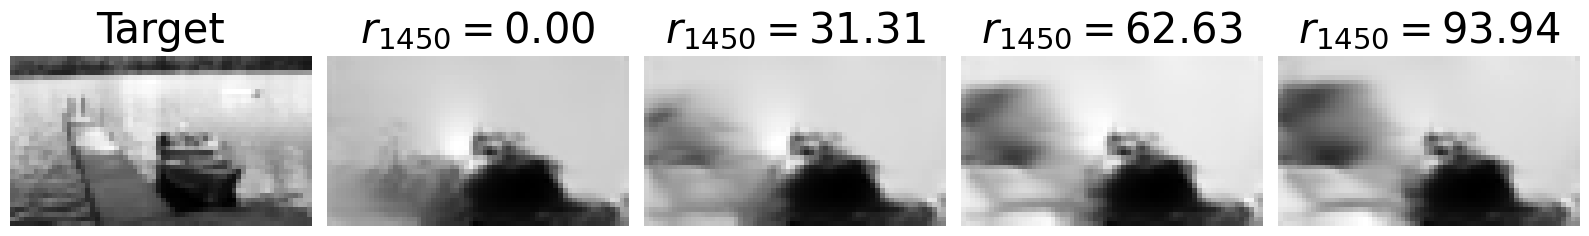

In [1742]:
print("\n--- Running Sensitivity Analysis ---")
print(f"Probing Neuron {NEURON_TO_PROBE} over response range [0.0, {max_resp_val:.2f}]")

# Store reconstructions
reconstructions = []
titles = []

with torch.no_grad():
    for resp_val in response_sweep:
        # Create a modified response vector
        modified_resp = base_resp.clone().unsqueeze(0) # Add batch dimension
        modified_resp[0, NEURON_TO_PROBE] = resp_val

        # Prepare other inputs with a batch dimension
        coords_input = base_coords.unsqueeze(0) if base_coords is not None else None
        pupil_input = base_pupil.unsqueeze(0) if base_pupil is not None else None
        
        # Generate reconstruction
        recon = decoder(
            modified_resp,
            data_key=DATA_KEY,
            neuron_coords=coords_input,
            pupil_center=pupil_input
        )
        reconstructions.append(recon.squeeze())
        titles.append(f"$r_{{{NEURON_TO_PROBE}}} = {resp_val:.2f}$")

# Prepend the target image
reconstructions.insert(0, base_stim.cpu())
titles.insert(0, "Target")

# Plot the results
print("Plotting sensitivity analysis results...")
plot_grid(reconstructions, titles, grid_shape=(1, 5), figsize=(16, 6), fontsize=30, save_to=os.path.join(SAVE_DIR, f"sensitivity_n{NEURON_TO_PROBE}_s{SAMPLE_IDX}.pdf") if SAVE_DIR else None)

### Analysis of context & neuron embeddings

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# Analyzing context & neuron embeddings
print("\n--- Analyzing Context & Neuron Embeddings ---")

# Visualize neuron embeddings with t-SNE ---
if mei_readin.neuron_emb_dim:
    print("Analyzing learned neuron embeddings...")
    
    # Get the embeddings
    neuron_embeddings = mei_readin.neuron_embed.weight.detach().cpu().numpy()
    n_neurons = neuron_embeddings.shape[0]

    # Use t-SNE to project embeddings to 2D
    tsne = TSNE(n_components=2, perplexity=10, n_iter=1000, random_state=42)
    embeddings_2d = tsne.fit_transform(neuron_embeddings)

    # For coloring, we can use a known property of neurons, like their nonlinearity or spatial position
    # Here, we'll just use their index as a proxy for spatial location
    df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'neuron_index': np.arange(n_neurons)
    })

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df, x='x', y='y', hue='neuron_index', palette='viridis', legend=None, s=50)
    plt.title('t-SNE Projection of learned neuron embeddings')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()
else:
    print("Skipping neuron embedding analysis: No embeddings in this model.")

# Visualize the context modulation maps
print("Visualizing the context modulation maps from ctx_net...")

# We will manually perform the forward pass of the MEIReadIn to inspect intermediates
with torch.no_grad():
    # Use the same base data point as before
    resp_input = base_resp.unsqueeze(0)
    coords_input = base_coords.unsqueeze(0) if base_coords is not None else None
    
    # Replicate the MEIReadIn forward pass
    B, n_neurons_batch = resp_input.shape
    
    # 1. Get MEIs
    meis = mei_readin.meis.expand(B, -1, -1, -1).to(device)

    # 2. Prepare context network input
    ctx_inp_list = [mei_readin.resp_transform(resp_input).unsqueeze(-1)]
    if mei_readin.use_neuron_coords:
        ctx_inp_list.append(coords_input[..., :2])
    if mei_readin.neuron_emb_dim:
        neuron_embeds = mei_readin.neuron_embed(torch.arange(n_neurons_batch, device=device))
        neuron_embeds = neuron_embeds.unsqueeze(0).repeat(B, 1, 1)
        ctx_inp_list.append(neuron_embeds)
    
    ctx_inp = torch.cat(ctx_inp_list, dim=-1).view(B * n_neurons_batch, -1)
    
    # 3. Get context network output (the modulation map)
    ctx_out = mei_readin.ctx_net(ctx_inp)
    ctx_modulation_map = ctx_out.view(B, n_neurons_batch, *meis.shape[-2:])

    # 4. Calculate the final modulated MEIs
    modulated_meis = meis * ctx_modulation_map

# Visualize for a few example neurons
neurons_to_viz = [50, NEURON_TO_PROBE, 250]
images_to_plot = []
titles_to_plot = []

for neuron_idx in neurons_to_viz:
    images_to_plot.append(meis[0, neuron_idx])
    titles_to_plot.append(f'Neuron {neuron_idx}\nBase MEI')
    
    images_to_plot.append(ctx_modulation_map[0, neuron_idx])
    titles_to_plot.append(f'Resp: {resp_input[0, neuron_idx]:.2f}\nContext Map')

    images_to_plot.append(modulated_meis[0, neuron_idx])
    titles_to_plot.append(f'Neuron {neuron_idx}\nModulated MEI')

plot_grid(images_to_plot, titles_to_plot, grid_shape=(len(neurons_to_viz), 3), figsize=(12, 12))

### Latent feature analysis with NMF

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
# Configuration for NMF Analysis
N_COMPONENTS = 16 # Number of basis features (concepts) to discover
N_SAMPLES_FOR_NMF = 500 # Use a subset of the data for efficiency

In [ ]:
# 1. Collect latent representations from the MEIReadIn block
print(f"Collecting {N_SAMPLES_FOR_NMF} latent representations...")
latent_representations = []
dataloader_iter = iter(dls[TIER][DATASET_NAME].dataloaders[0])

with torch.no_grad():
    for _ in range(N_SAMPLES_FOR_NMF // sample_batch.responses.shape[0] + 1):
        try:
            batch = next(dataloader_iter)
        except StopIteration:
            break # End of dataloader
            
        resp = batch.responses.to(device)
        coords = batch.neuron_coords.to(device) if hasattr(batch, 'neuron_coords') else None
        pupil = batch.pupil_center.to(device) if hasattr(batch, 'pupil_center') else None

        # Get the output of the MEIReadIn block (the latent representation)
        latent_rep = mei_readin(resp, neuron_coords=coords, pupil_center=pupil)
        latent_representations.append(latent_rep.cpu())

all_latents = torch.cat(latent_representations, dim=0)[:N_SAMPLES_FOR_NMF]
print(f"Collected latents shape: {all_latents.shape}")

In [ ]:
# 2. Prepare data for NMF

# NMF requires a 2D array (n_samples, n_features) and non-negative values.
n_samples, n_channels, h, w = all_latents.shape

# Flatten the channel and spatial dimensions
flattened_latents = all_latents.view(n_samples, -1).numpy()

# Ensure non-negativity (a requirement for NMF)
print(f"Percentage of negative values in latents: {(flattened_latents < 0).mean() * 100:.2f}%")
flattened_latents[flattened_latents < 0] = 0

print(f"Flattened latents for NMF, shape: {flattened_latents.shape}")

In [ ]:
# 3. Fit NMF
print(f"Fitting NMF with {N_COMPONENTS} components...")
nmf = NMF(n_components=N_COMPONENTS, init='random', random_state=0, max_iter=500, tol=1e-3)
W = nmf.fit_transform(flattened_latents) # The weights for each sample
H = nmf.components_ # The basis features (n_components, n_features)

print("NMF fitting complete.")

In [ ]:
# 4. Visualize the learned basis features
print("Visualizing NMF components (basis features)...")
nmf_components = torch.from_numpy(H).view(N_COMPONENTS, n_channels, h, w)

# To visualize the multi-channel components, we can take the mean across the channel dimension
components_to_plot = nmf_components.mean(dim=1)

plot_grid(
    components_to_plot,
    [f'Component {i+1}' for i in range(N_COMPONENTS)],
    grid_shape=(4, 8),
    figsize=(16, 8)
)

### MDS to recover neuron coordinates

In [ ]:
neuron_coords = cfg["data"]["brainreader_mouse"]["neuron_coords"][DATA_KEY]
neuron_coords

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

# --- Setup & Configuration ---
# Assume `mei_readin` is your loaded MEIReadIn module
# Assume `neuron_coords` is a pre-existing global tensor of shape (N_neurons, 2)
# Assume the model is in eval mode and on the correct device

# Make sure the global neuron_coords is on the CPU for analysis
# This is a defensive check; it might already be a numpy array or on the CPU.
if torch.is_tensor(neuron_coords):
    true_coords = neuron_coords.cpu().numpy()
else:
    true_coords = np.array(neuron_coords)

# --- Step 1: Extract Neuron Embeddings ---

if not mei_readin.neuron_emb_dim:
    print("Skipping neuron embedding analysis: No embeddings in this model.")
else:
    print("--- Running Analysis: Recovering Spatial Coordinates from Neuron Embeddings ---")

    # Get the learned embeddings
    neuron_embeddings = mei_readin.neuron_embed.weight.detach().cpu().numpy()
    n_neurons_model = neuron_embeddings.shape[0]
    n_neurons_coords = true_coords.shape[0]

    print(f"Extracted {n_neurons_model} neuron embeddings of dimension {neuron_embeddings.shape[1]}.")
    print(f"Using global ground truth coordinates for {n_neurons_coords} neurons.")

    # Sanity check
    if n_neurons_model != n_neurons_coords:
        print(f"🚨 WARNING: Mismatch between number of neurons in model ({n_neurons_model}) and coordinates ({n_neurons_coords}).")
        # Decide how to handle this - e.g., trim or error out. For now, we'll proceed but this is important.
        min_n = min(n_neurons_model, n_neurons_coords)
        neuron_embeddings = neuron_embeddings[:min_n]
        true_coords = true_coords[:min_n]
        print(f"Proceeding with the first {min_n} neurons.")

    # --- Step 2: Apply Multidimensional Scaling (MDS) ---
    print("Applying MDS to project embeddings into 2D space...")

    mds = MDS(
        n_components=2,
        random_state=42,
        dissimilarity='euclidean',
        n_init=4,
        max_iter=300,
        n_jobs=-1,
        normalized_stress='auto'
    )

    # Fit MDS to the high-dimensional embeddings
    recovered_coords = mds.fit_transform(neuron_embeddings)
    print("MDS fitting complete.")

    # --- Step 3: Align the Recovered Coordinates to the True Coordinates ---
    # Check correlation to see if axes need flipping for better visualization
    corr_x = np.corrcoef(true_coords[:, 0], recovered_coords[:, 0])[0, 1]
    corr_y = np.corrcoef(true_coords[:, 1], recovered_coords[:, 1])[0, 1]
    
    if corr_x < 0:
        recovered_coords[:, 0] *= -1 # Flip x-axis
    if corr_y < 0:
        recovered_coords[:, 1] *= -1 # Flip y-axis

    # --- Step 4: Visualize and Compare ---
    print("Visualizing results...")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Ground Truth Neuron Coordinates
    ax1 = axes[0]
    sns.scatterplot(x=true_coords[:, 0], y=true_coords[:, 1], hue=true_coords[:, 0], palette='viridis', legend=None, ax=ax1, s=20)
    ax1.set_title("Ground Truth Neuron Coordinates (Retinotopy)", fontsize=14)
    ax1.set_xlabel("Horizontal Position (x)")
    ax1.set_ylabel("Vertical Position (y)")
    ax1.set_aspect('equal', adjustable='box')

    # Plot 2: MDS-Recovered Coordinates from Embeddings
    ax2 = axes[1]
    sns.scatterplot(x=recovered_coords[:, 0], y=recovered_coords[:, 1], hue=true_coords[:, 0], palette='viridis', legend=None, ax=ax2, s=20)
    ax2.set_title("MDS-Recovered Coordinates from Embeddings", fontsize=14)
    ax2.set_xlabel("MDS Dimension 1")
    ax2.set_ylabel("MDS Dimension 2")
    ax2.set_aspect('equal', adjustable='box')

    plt.suptitle("Does MEIcoder Implicitly Learn Neuron Spatial Layout?", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # --- Step 5: Quantitative Evaluation ---
    # Calculate the correlation between pairwise distances in both spaces
    true_dist_matrix = pairwise_distances(true_coords)
    recovered_dist_matrix = pairwise_distances(recovered_coords)
    
    true_dists_flat = true_dist_matrix[np.triu_indices_from(true_dist_matrix, k=1)]
    recovered_dists_flat = recovered_dist_matrix[np.triu_indices_from(recovered_dist_matrix, k=1)]
    
    dist_corr = np.corrcoef(true_dists_flat, recovered_dists_flat)[0, 1]
    print(f"\nQuantitative Analysis:")
    print(f"Correlation of pairwise distances between true and recovered coordinates: {dist_corr:.4f}")
    print("(A higher value indicates better preservation of the spatial manifold.)")

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import pairwise_distances
import umap # Make sure you have umap-learn installed

# --- Setup & Configuration ---
# Assume `mei_readin` is your loaded MEIReadIn module
# Assume `neuron_coords` is a pre-existing global tensor of shape (N_neurons, 2)
# Assume the model is in eval mode and on the correct device

# Make sure the global neuron_coords is a CPU-side NumPy array
if torch.is_tensor(neuron_coords):
    true_coords = neuron_coords.cpu().numpy()
else:
    true_coords = np.array(neuron_coords)

# --- Step 1: Extract Neuron Embeddings ---

if not mei_readin.neuron_emb_dim:
    print("Skipping neuron embedding analysis: No embeddings in this model.")
else:
    print("--- Running Analysis: Recovering Spatial Coordinates from Neuron Embeddings using UMAP ---")

    # Get the learned embeddings
    neuron_embeddings = mei_readin.neuron_embed.weight.detach().cpu().numpy()
    n_neurons_model = neuron_embeddings.shape[0]
    n_neurons_coords = true_coords.shape[0]

    print(f"Extracted {n_neurons_model} neuron embeddings of dimension {neuron_embeddings.shape[1]}.")
    print(f"Using global ground truth coordinates for {n_neurons_coords} neurons.")

    # Sanity check for neuron count mismatch
    if n_neurons_model != n_neurons_coords:
        print(f"🚨 WARNING: Mismatch between number of neurons in model ({n_neurons_model}) and coordinates ({n_neurons_coords}).")
        min_n = min(n_neurons_model, n_neurons_coords)
        neuron_embeddings = neuron_embeddings[:min_n]
        true_coords = true_coords[:min_n]
        print(f"Proceeding with the first {min_n} neurons.")

    # --- Step 2: Apply UMAP ---
    print("Applying UMAP to project embeddings into 2D space...")

    # UMAP is better at capturing non-linear manifold structures than MDS.
    # Key parameters: n_neighbors controls local vs. global focus, min_dist controls packing.
    reducer = umap.UMAP(
        n_neighbors=7,  # A good default, balances local/global structure
        min_dist=0.1,    # Allows points to be tightly packed
        n_components=2,
        metric='euclidean',
        random_state=42
    )

    # Fit UMAP to the high-dimensional embeddings
    recovered_coords = reducer.fit_transform(neuron_embeddings)
    print("UMAP fitting complete.")

    # --- Step 3: Align the Recovered Coordinates (Optional but recommended) ---
    # UMAP output is also invariant to rotation/reflection. We can align for better visual comparison.
    corr_x = np.corrcoef(true_coords[:, 0], recovered_coords[:, 0])[0, 1]
    corr_y = np.corrcoef(true_coords[:, 1], recovered_coords[:, 1])[0, 1]
    
    if corr_x < 0:
        recovered_coords[:, 0] *= -1 # Flip x-axis
    if corr_y < 0:
        recovered_coords[:, 1] *= -1 # Flip y-axis

    # --- Step 4: Visualize and Compare ---
    print("Visualizing results...")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Ground Truth Neuron Coordinates
    ax1 = axes[0]
    sns.scatterplot(x=true_coords[:, 0], y=true_coords[:, 1], hue=true_coords[:, 0], palette='viridis', legend=None, ax=ax1, s=20)
    ax1.set_title("Ground Truth Neuron Coordinates (Retinotopy)", fontsize=14)
    ax1.set_xlabel("Horizontal Position (x)")
    ax1.set_ylabel("Vertical Position (y)")
    ax1.set_aspect('equal', adjustable='box')

    # Plot 2: UMAP-Recovered Coordinates from Embeddings
    ax2 = axes[1]
    sns.scatterplot(x=recovered_coords[:, 0], y=recovered_coords[:, 1], hue=true_coords[:, 0], palette='viridis', legend=None, ax=ax2, s=20)
    ax2.set_title("UMAP-Recovered Coordinates from Embeddings", fontsize=14)
    ax2.set_xlabel("UMAP Dimension 1")
    ax2.set_ylabel("UMAP Dimension 2")
    ax2.set_aspect('equal', adjustable='box')

    plt.suptitle("Does MEIcoder Implicitly Learn Neuron Spatial Layout?", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # --- Step 5: Quantitative Evaluation ---
    true_dist_matrix = pairwise_distances(true_coords)
    recovered_dist_matrix = pairwise_distances(recovered_coords)
    
    true_dists_flat = true_dist_matrix[np.triu_indices_from(true_dist_matrix, k=1)]
    recovered_dists_flat = recovered_dist_matrix[np.triu_indices_from(recovered_dist_matrix, k=1)]
    
    dist_corr = np.corrcoef(true_dists_flat, recovered_dists_flat)[0, 1]
    print(f"\nQuantitative Analysis:")
    print(f"Correlation of pairwise distances between true and recovered coordinates: {dist_corr:.4f}")
    print("(A higher value indicates better preservation of the spatial manifold.)")

### Sensitivity analysis + NMF

In [10]:
from sklearn.decomposition import NMF

In [11]:
class AnalysisHook:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.output = None

    def hook_fn(self, module, input, output):
        self.output = output.detach()

    def close(self):
        self.hook.remove()

In [12]:
class NMFInterpreter:
    def __init__(self, nmf_model, nmf_input_shape):
        """
        Initializes the interpreter with a pre-trained NMF model.

        Args:
            nmf_model (sklearn.decomposition.NMF): A fitted NMF model.
            nmf_input_shape (tuple): The original shape of the feature maps used to train NMF (e.g., C, H, W).
        """
        self.nmf = nmf_model
        self.nmf_input_shape = nmf_input_shape
        self.n_components = nmf_model.n_components_
        self.components = torch.from_numpy(nmf_model.components_).view(self.n_components, *self.nmf_input_shape)

    def project(self, feature_map):
        """Projects a feature map onto the NMF components to get weights."""
        if feature_map.ndim == 3: # Add batch dimension if missing
            feature_map = feature_map.unsqueeze(0)
            
        B, C, H, W = feature_map.shape
        
        # Prepare for projection
        flat_feature_map = feature_map.view(B, -1).cpu().numpy()
        print(f"Fraction of values below zero in feature map: {(flat_feature_map < 0).mean() * 100:.2f}%")
        flat_feature_map[flat_feature_map < 0] = 0 # Ensure non-negativity

        # Project to get the weights (W matrix)
        weights = self.nmf.transform(flat_feature_map)
        return torch.from_numpy(weights)

    def analyze_neuron_sensitivity(self, decoder, base_stim, base_resp, base_coords, base_pupil, data_key, neuron_idx,
                                   target_layer_hook, base_resp_val=0.0, increased_resp_val=1.0, k_top_features=4):
        """
        Performs the full sensitivity analysis and generates the visualization.
        """
        # 1. Generate reconstructions and get latent weights for base and increased response
        with torch.no_grad():
            # Base case
            resp_base = base_resp.clone().unsqueeze(0)
            resp_base[0, neuron_idx] = base_resp_val
            recon_base = decoder(resp_base, data_key=data_key, neuron_coords=base_coords, pupil_center=base_pupil)
            weights_base = self.project(target_layer_hook.output)

            # Increased response case
            resp_increased = base_resp.clone().unsqueeze(0)
            resp_increased[0, neuron_idx] = increased_resp_val
            recon_increased = decoder(resp_increased, data_key=data_key, neuron_coords=base_coords, pupil_center=base_pupil)
            weights_increased = self.project(target_layer_hook.output)

        # 2. Analyze weight changes
        weight_change = weights_increased - weights_base
        top_k_indices = torch.topk(weight_change.squeeze(), k=k_top_features).indices
        top_k_features = self.components[top_k_indices]

        return {
            'recon_base': recon_base.squeeze(),
            'recon_increased': recon_increased.squeeze(),
            'weights_base': weights_base.squeeze(),
            'weights_increased': weights_increased.squeeze(),
            'weight_change': weight_change.squeeze(),
            'top_k_indices': top_k_indices,
            'top_k_features': top_k_features
        }

In [13]:
# Config for NMF fitting

# Data
DATASET_NAME = "brainreader_mouse"
DATA_KEY = "6"
TIER = "val"

# NMF
N_SAMPLES_FOR_NMF = 400
N_COMPONENTS = 16
nmf_models = dict() # collect NMF models for multiple layers
device = cfg["device"]

# Layers to analyze by fitting NMF on their feature maps
layers_to_probe = {
    'readin': decoder.readins[DATA_KEY][0],  # MEIReadIn module
    'core_cnn_layer_0': decoder.core.G.layers[0],  # Example: 0th layer in the core CNN
    'core_cnn_layer_2': decoder.core.G.layers[2],  # Example: 0th layer in the core CNN
    'core_cnn_layer_4': decoder.core.G.layers[4],
    'core_cnn_layer_6': decoder.core.G.layers[6],
    'core_cnn_layer_8': decoder.core.G.layers[8],
    'core_cnn_layer_10': decoder.core.G.layers[10],
    'core_cnn_layer_12': decoder.core.G.layers[12],
    'core_cnn_layer_14': decoder.core.G.layers[14],
    'core_cnn_layer_16': decoder.core.G.layers[16],
    'core_cnn_layer_20': decoder.core.G.layers[20],  # last layer
}

In [14]:
# Collect per-layer data and fit separate NMF models on them
for layer_to_probe_name, layer_to_probe in layers_to_probe.items():
    print(f"--- Preparing NMF for layer: '{layer_to_probe_name}' ---")
    print(f"Layer module: {layer_to_probe}")
    
    # Attach a hook to the chosen layer to capture its outputs
    hook = AnalysisHook(module=layer_to_probe)

    # Collect feature maps from this layer to train NMF
    feature_maps = []
    dataloader = dls[TIER][DATASET_NAME].dataloaders[0]

    print(f"Collecting {N_SAMPLES_FOR_NMF} feature maps from '{layer_to_probe_name}'...")
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if len(feature_maps) * batch.responses.shape[0] >= N_SAMPLES_FOR_NMF:
                break
            
            # A forward pass is needed to trigger the hook
            _ = decoder(batch.responses.to(device), data_key=DATA_KEY, 
                        neuron_coords=batch.neuron_coords.to(device) if hasattr(batch, 'neuron_coords') else None, 
                        pupil_center=batch.pupil_center.to(device) if hasattr(batch, 'pupil_center') else None)
            feature_maps.append(hook.output.cpu())

    hook.close() # Detach the hook now that we have the data

    # Prepare data and fit NMF
    all_features = torch.cat(feature_maps, dim=0)[:N_SAMPLES_FOR_NMF]
    print(f"Collected feature maps shape: {all_features.shape}")
    flat_features = all_features.view(all_features.shape[0], -1).numpy()
    flat_features[flat_features < 0] = 0 # NMF requires non-negative data

    print(f"Fitting NMF with {N_COMPONENTS} components...")
    nmf_models[layer_to_probe_name] = NMF(n_components=N_COMPONENTS, init='random', random_state=42, max_iter=500, tol=1e-3)
    nmf_models[layer_to_probe_name].fit(flat_features)
    nmf_models[layer_to_probe_name].feature_map_shape = all_features.shape[1:] # (C, H, W) Store the input shape for later use
    print("NMF fitting complete.")

--- Preparing NMF for layer: 'readin' ---
Layer module: MEIReadIn(
  (pointwise_conv): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8587, 480, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (resp_transform): Identity()
  (ctx_net): Sequential(
    (0): Linear(in_features=33, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.15, inplace=False)
    (4): Linear(in_features=128, out_features=2304, bias=True)
    (5): Identity()
  )
  (neuron_embed): Embedding(8587, 32)
)
Collected feature maps shape: torch.Size([400, 480, 36, 64])
Fitting NMF with 16 components...
NMF fitting complete.
--- Preparing NMF for layer: 'core_cnn_layer_0' ---
Layer module: Conv2d(480, 480, kernel_size=(7, 7), stride=(1, 1), pad

In [ ]:
# Config for sensitivity analysis
NEURON_TO_PROBE = 5058  # Neuron index to analyze
DP_IDX = 1
BASE_RESP_VAL = 0.0
# INCREASED_RESP_VAL = 300
INCREASED_RESP_VAL = 10 * np.percentile(all_data[DATA_KEY]["resp"][..., NEURON_TO_PROBE], 99) if np.any(all_data[DATA_KEY]["resp"][..., NEURON_TO_PROBE] > 0) else 1.0
TOP_K_FEATURES = 3
EVAL_ON_TIER = "test"

# SAVE_DIR = None
SAVE_DIR = f"./nmf_sensitivity_analysis_results/{DATASET_NAME}_dk{DATA_KEY}_dp{DP_IDX}_n{NEURON_TO_PROBE}"
if SAVE_DIR is not None:
    os.makedirs(SAVE_DIR, exist_ok=True)

print(f'Fitted neural coordinates: {cfg["data"]["brainreader_mouse"]["neuron_coords"][DATA_KEY][NEURON_TO_PROBE]}')
print(f"Saving results to: {SAVE_DIR}")

Fitted neural coordinates: tensor[2] μ=-0.138 σ=0.522 cuda:0 [0.231, -0.507]
Saving results to: ./sensitivity_analysis_results/brainreader_mouse_dk6_dp1_n5058


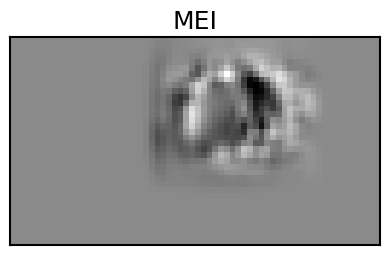

In [397]:
# Plot neuron's MEI
with torch.no_grad():
    neuron_mei = decoder.readins[DATA_KEY][0].meis[0, NEURON_TO_PROBE].cpu()
plt.figure(figsize=(4, 4))
plt.imshow(neuron_mei.squeeze(), cmap='gray')
plt.title(f"MEI", fontsize=18)
# plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
# Make border thicker
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
if SAVE_DIR is not None:
    plt.savefig(os.path.join(SAVE_DIR, f"n{NEURON_TO_PROBE}_MEI.pdf"), dpi=300, bbox_inches='tight')
plt.show()

In [398]:
def plot_reconstructions_and_concept_gains(
    base_stim, recon_base, recon_increased, top_k_features, top_k_indices,
    weight_change, base_resp_val, increased_resp_val
):
    fig, axes = plt.subplots(1, 4 + len(top_k_features), figsize=(4 + (len(top_k_features) * 3.5), int(len(top_k_features) * 0.75)))
    # plt.suptitle(f"Sensitivity Analysis for Neuron {neuron_idx} (Response {base_resp_val:.2f} -> {increased_resp_val:.2f})", fontsize=16)

    # a) Original image
    axes[0].imshow(base_stim.cpu().squeeze(), cmap='gray')
    axes[0].set_title("Original Stimulus")
    axes[0].axis('off')

    # b) Base reconstruction
    axes[1].imshow(recon_base.cpu().squeeze().detach(), cmap='gray')
    axes[1].set_title(f"Reconstruction\n(Base resp: {base_resp_val:.2f})")
    axes[1].axis('off')
    
    # c) Increased reconstruction
    axes[2].imshow(recon_increased.cpu().squeeze().detach(), cmap='gray')
    axes[2].set_title(f"Reconstruction\n(Increased resp: {increased_resp_val:.2f})")
    axes[2].axis('off')
    
    # Separator
    axes[3].axis('off')
    axes[3].text(0.5, 0.5, 'Top Gaining\nNMF Features ->', ha='center', va='center', fontsize=12)

    # d) Top-k basis features
    for i in range(len(top_k_features)):
        ax = axes[4 + i]
        # Visualize multi-channel components by taking the mean
        feature_to_show = top_k_features[i].mean(dim=0)
        ax.imshow(feature_to_show, cmap='gray')
        ax.set_title(f"Feature {top_k_indices[i].item()}\n(Gain: {weight_change[top_k_indices[i]]:.3f})")
        ax.axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [399]:
def plot_activated_concepts(
    top_k_features, top_k_indices, weight_change, titles=None, save_to=None,
):
    fig, axes = plt.subplots(1, len(top_k_features), figsize=(len(top_k_features) * 3.5, 3))
    for i in range(len(top_k_features)):
        ax = axes[i]
        # Visualize multi-channel components by taking the mean
        feature_to_show = top_k_features[i].mean(dim=0)
        ax.imshow(feature_to_show, cmap='gray')
        if titles is not None:
            ax.set_title(titles[i])
        # ax.set_title(f"Feature {top_k_indices[i].item()}\n(Gain: {weight_change[top_k_indices[i]]:.3f})")
        # ax.axis('off')
        # Just remove ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Add border around images
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.5)

    plt.tight_layout()
    if save_to is not None:
        plt.savefig(save_to, dpi=300, bbox_inches='tight')
    plt.show()

--- Running Combined Sensitivity & NMF Analysis for Neuron 5058 ---


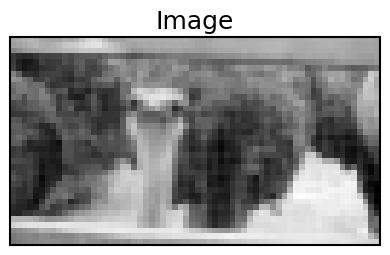

--- Analyzing Layer: readin ---
Fraction of values below zero in feature map: 51.64%
Fraction of values below zero in feature map: 51.58%


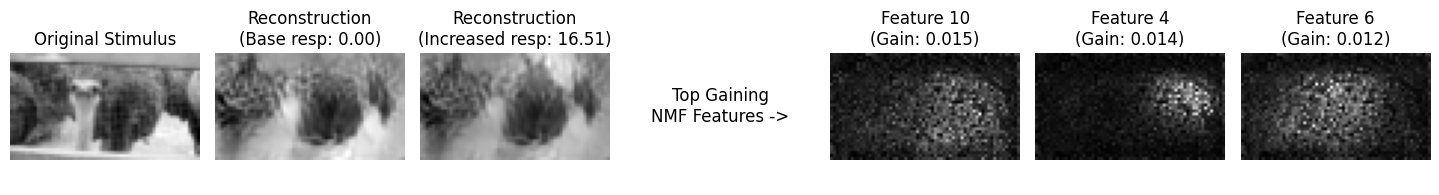

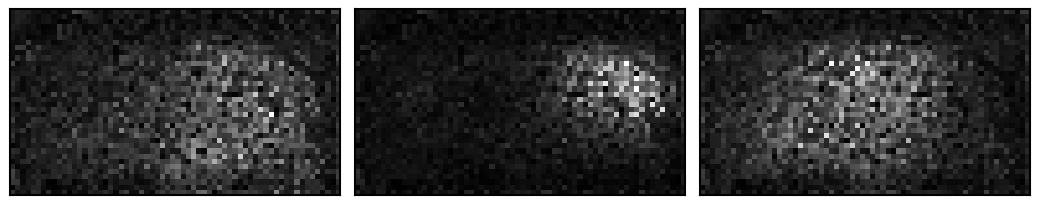

--- Analyzing Layer: core_cnn_layer_0 ---
Fraction of values below zero in feature map: 79.50%
Fraction of values below zero in feature map: 78.43%


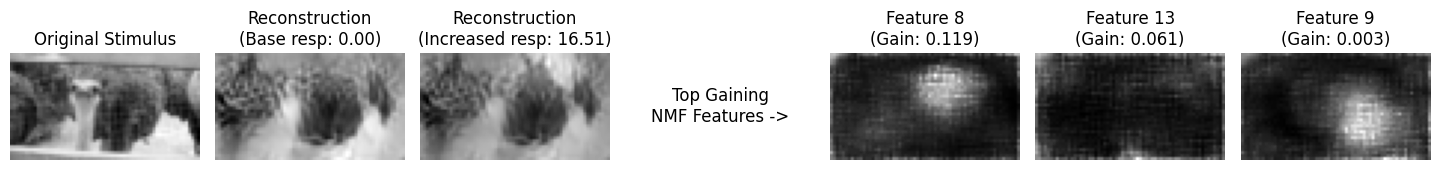

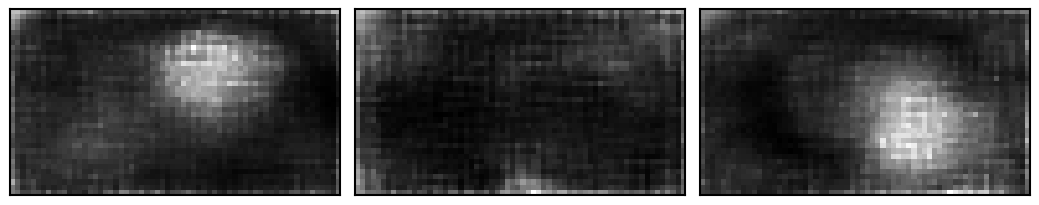

--- Analyzing Layer: core_cnn_layer_2 ---
Fraction of values below zero in feature map: 0.00%
Fraction of values below zero in feature map: 0.00%


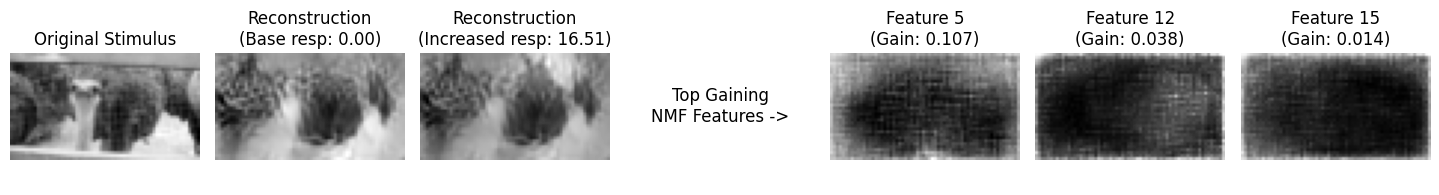

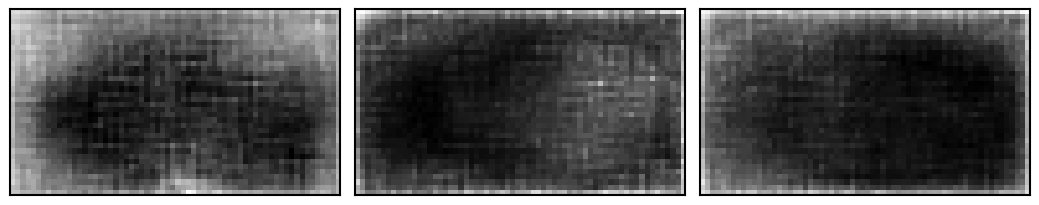

--- Analyzing Layer: core_cnn_layer_4 ---
Fraction of values below zero in feature map: 62.87%
Fraction of values below zero in feature map: 62.29%


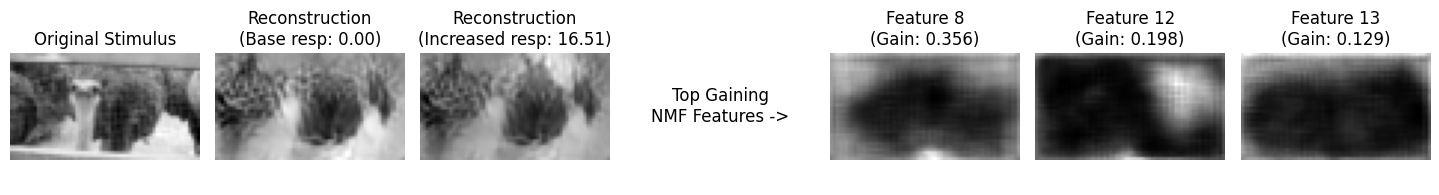

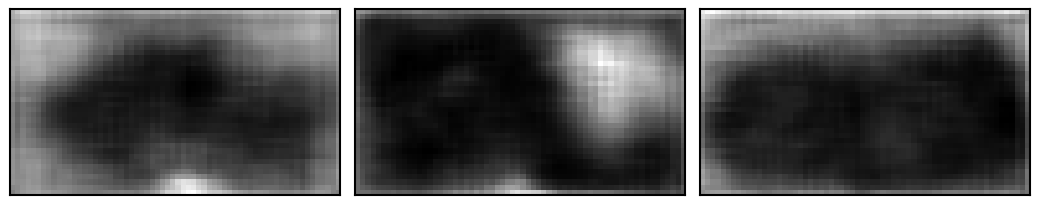

--- Analyzing Layer: core_cnn_layer_6 ---
Fraction of values below zero in feature map: 0.00%
Fraction of values below zero in feature map: 0.00%


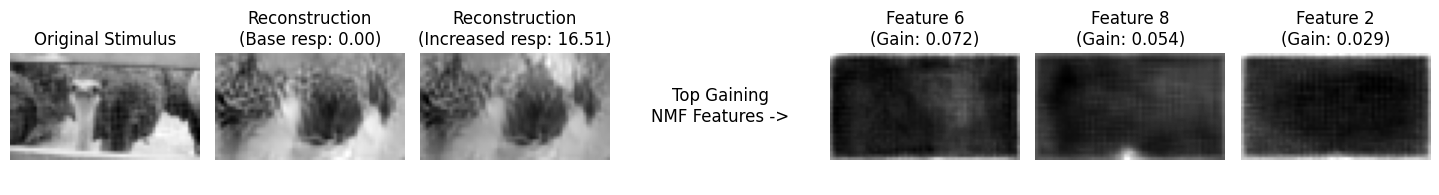

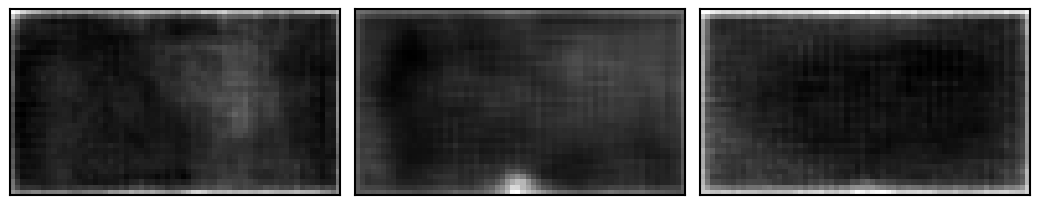

--- Analyzing Layer: core_cnn_layer_8 ---
Fraction of values below zero in feature map: 61.46%
Fraction of values below zero in feature map: 60.99%


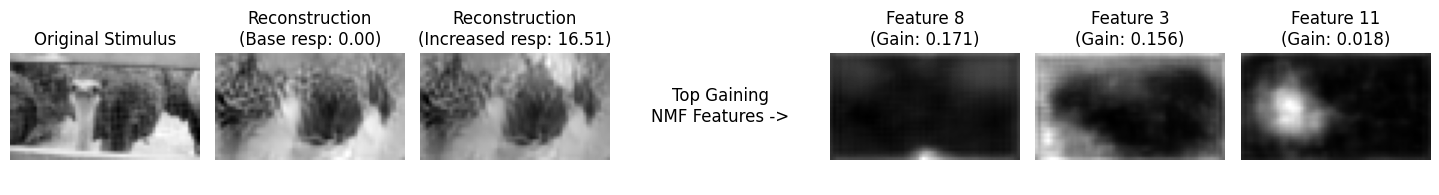

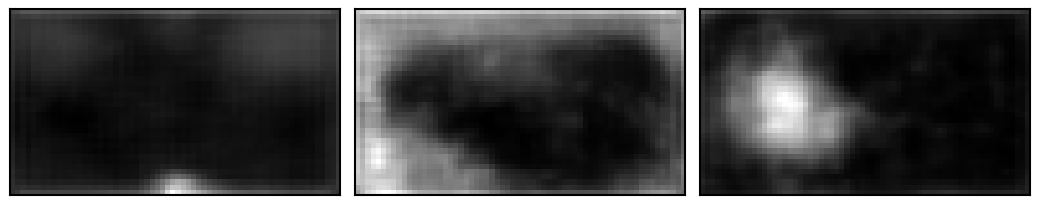

--- Analyzing Layer: core_cnn_layer_10 ---
Fraction of values below zero in feature map: 0.00%
Fraction of values below zero in feature map: 0.00%


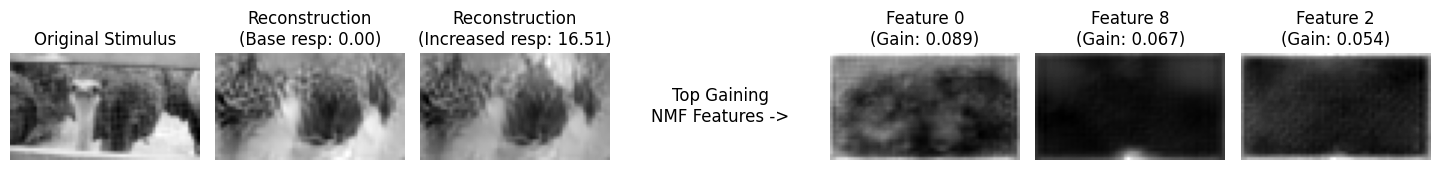

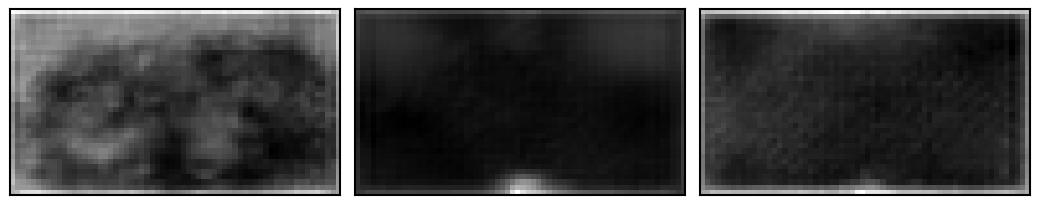

--- Analyzing Layer: core_cnn_layer_12 ---
Fraction of values below zero in feature map: 68.35%
Fraction of values below zero in feature map: 67.34%


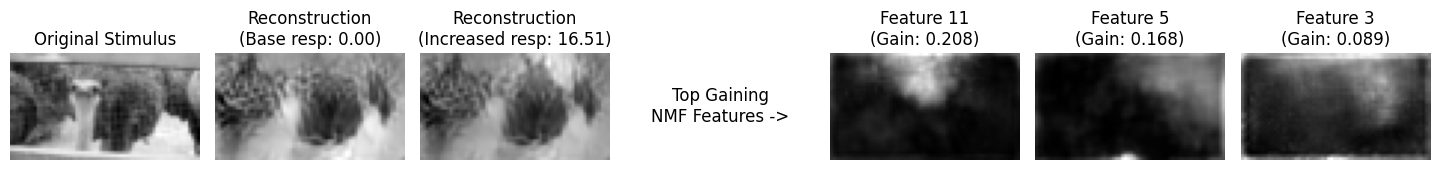

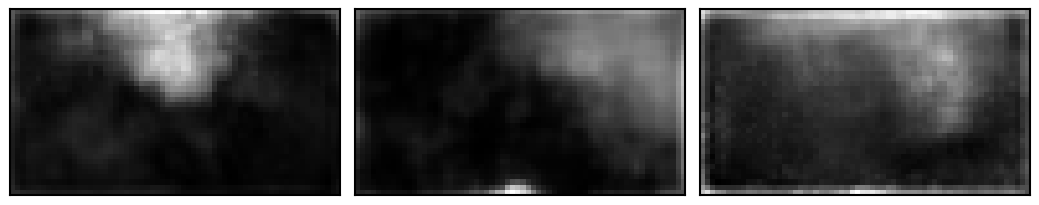

--- Analyzing Layer: core_cnn_layer_14 ---
Fraction of values below zero in feature map: 0.00%
Fraction of values below zero in feature map: 0.00%


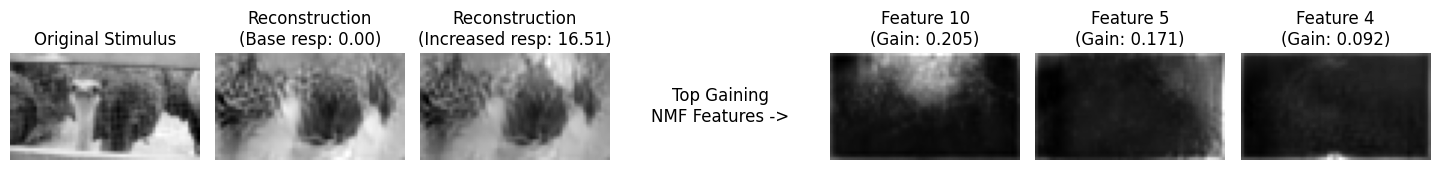

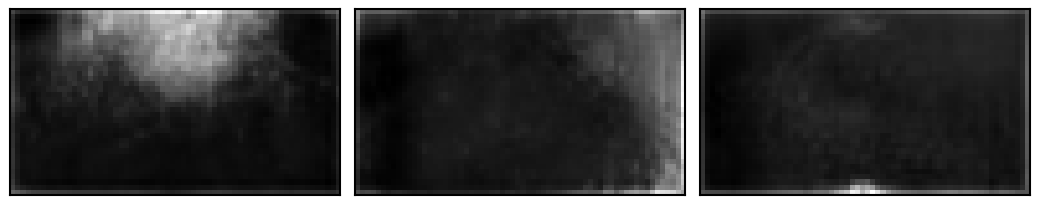

--- Analyzing Layer: core_cnn_layer_16 ---
Fraction of values below zero in feature map: 87.27%
Fraction of values below zero in feature map: 83.62%


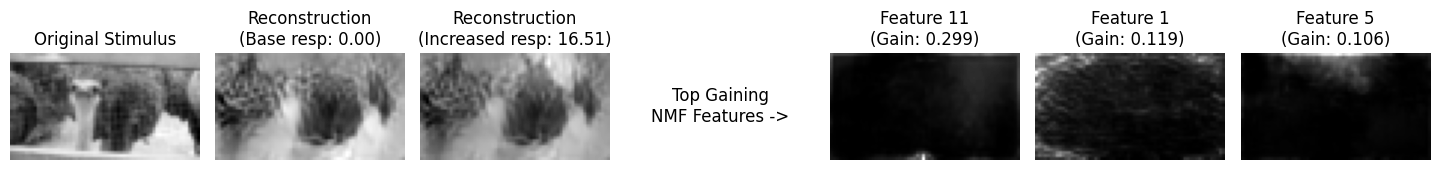

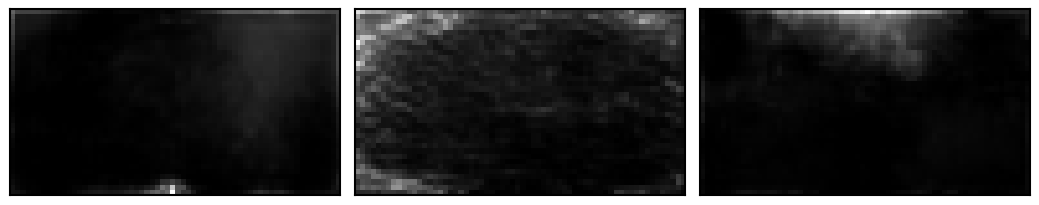

--- Analyzing Layer: core_cnn_layer_20 ---
Fraction of values below zero in feature map: 27.52%
Fraction of values below zero in feature map: 25.43%


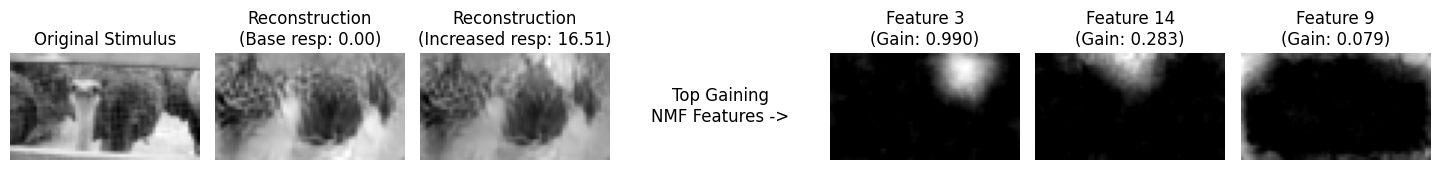

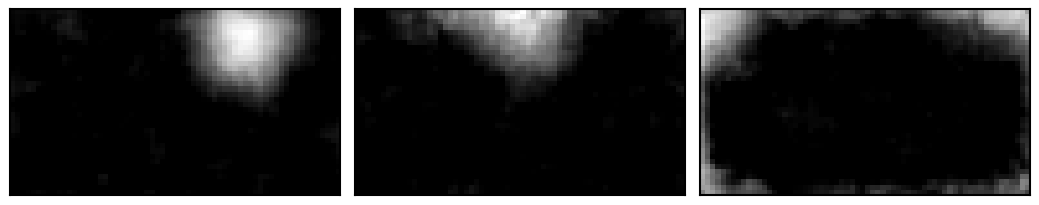

In [400]:
# Perform sensitivity analysis using the fitted NMF models ---
print(f"--- Running Combined Sensitivity & NMF Analysis for Neuron {NEURON_TO_PROBE} ---")

# Get a sample batch from the dataloader
sample_batch = next(iter(dls[EVAL_ON_TIER]["brainreader_mouse"].dataloaders[0]))
device = next(decoder.parameters()).device
base_stim = sample_batch.images[DP_IDX].to(device)
base_resp = sample_batch.responses[DP_IDX].to(device)
base_coords = sample_batch.neuron_coords.to(device) if hasattr(sample_batch, 'neuron_coords') else None
base_pupil = sample_batch.pupil_center.to(device) if hasattr(sample_batch, 'pupil_center') else None

# Plot base stimulus
plt.figure(figsize=(4, 4))
plt.imshow(base_stim.cpu().squeeze(), cmap='gray')
plt.title("Image", fontsize=18)
# plt.axis('off')
plt.xticks([])
plt.yticks([])
# Make border thicker
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.tight_layout()
if SAVE_DIR is not None:
    plt.savefig(os.path.join(SAVE_DIR, f"n{NEURON_TO_PROBE}_base_stim.pdf"), dpi=300, bbox_inches='tight')
plt.show()

for layer_to_probe_name, layer_to_probe in layers_to_probe.items():
    print(f"--- Analyzing Layer: {layer_to_probe_name} ---")

    # Get the NMF model and input shape for this layer
    nmf_model = nmf_models[layer_to_probe_name]
    nmf_input_shape = nmf_model.feature_map_shape  # (C, H, W)

    # Instantiate the interpreter
    interpreter = NMFInterpreter(nmf_model=nmf_model, nmf_input_shape=nmf_input_shape)

    # Re-attach the hook to the same layer for the analysis pass
    analysis_hook = AnalysisHook(module=layer_to_probe)

    # Run the analysis
    activation_results = interpreter.analyze_neuron_sensitivity(
        decoder=decoder,
        base_stim=base_stim,
        base_resp=base_resp,
        base_coords=base_coords,
        base_pupil=base_pupil,
        data_key=DATA_KEY,
        neuron_idx=NEURON_TO_PROBE,
        target_layer_hook=analysis_hook,
        base_resp_val=BASE_RESP_VAL,
        increased_resp_val=INCREASED_RESP_VAL,
        k_top_features=TOP_K_FEATURES
    )

    # Plot the results
    plot_reconstructions_and_concept_gains(
        base_stim=base_stim,
        recon_base=activation_results['recon_base'],
        recon_increased=activation_results['recon_increased'],
        top_k_features=activation_results['top_k_features'],
        top_k_indices=activation_results['top_k_indices'],
        weight_change=activation_results['weight_change'],
        base_resp_val=BASE_RESP_VAL,
        increased_resp_val=INCREASED_RESP_VAL
    )

    plot_activated_concepts(
        top_k_features=activation_results['top_k_features'],
        top_k_indices=activation_results['top_k_indices'],
        weight_change=activation_results['weight_change'],
        save_to=os.path.join(SAVE_DIR, f"activated_concepts_l{layer_to_probe_name}_n{NEURON_TO_PROBE}.pdf") if SAVE_DIR is not None else None
    )

    # Clean up the hook
    analysis_hook.close()